In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

if not os.getcwd().endswith('mob2crime'):
    os.chdir('..')
import folium

import src.mex_helper as mex_helper
import src.mex as mex
import src.mex.regions2010 as region
import src.mex.tower as tower
import src.tower_interpolation as tw_int
import src.utils.map_vis as mvis
import src.utils.gis as gis

from src.utils.map_vis import time_slider_choropleth, geojson_per_row
import src.ftrs.dilatation as ftr_dv

In [3]:
import pandas as pd
import src.features as ftr
import numpy as np

In [4]:
import geopandas as gp

In [ ]:
zms = region.mpa_all()
zms['Area'] = zms.area
# zms_area = zms.to_crs(mex.crs).geometry.apply(lambda x: x.area)
zms_sqrt_area = np.sqrt(zms.Area)

In [ ]:
zms_g2000 = region.mpa_grids(side=2000, per_mun=False)

# interpolate

In [5]:
call_direction = 'out+in'
aver = mex_helper.stat_tw_dow_aver_hr_uniq_user(call_direction)
avg_tw = pd.DataFrame(aver['wd']).T

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle


# dilitation

In [35]:
t2g2000_area = tw_int.to_mpa_grids(2000, by='area', per_mun=False)
t2g2000_area.set_index('grid', inplace=True)
avg_g2000_area = tw_int.interpolate_stats(avg_tw, t2g2000_area)

to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g2000_by_area.csv


In [21]:
gs_avg_idw2000 = tw_int.interpolate_idw(None, 2000, False)

interpolate_idw loading existing file data/mex_tw_intpl/interpolate_idw10_g2000.csv


In [36]:
dv_g2000_a = ftr_dv.dv_for_mpa_grids(avg_g2000_area, zms, zms_g2000)

In [38]:
%matplotlib inline

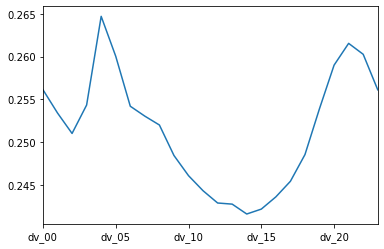

In [39]:
dv_g2000_a.loc[zms.index].iloc[0,:-1].plot()

# sampling moment of inertia

## Moment of Inertia in vector form

In [391]:
sub_target_hs = target_hs.iloc[27:30]

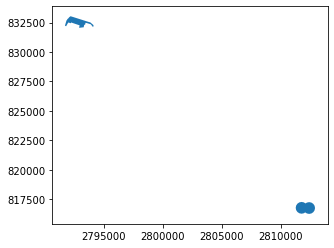

In [392]:
sub_target_hs.plot()

In [393]:
sub_target_hs_centroid = cascaded_union(sub_target_hs.geometry).centroid

In [394]:
sub_g = gis.gp_polys_to_grids(sub_target_hs, side=100, no_grid_by_area=True)

In [395]:
g_x = sub_g.centroid.apply(lambda x: x.coords[0][0])
g_y = sub_g.centroid.apply(lambda x: x.coords[0][1])


cx = (g_x*sub_g.area).sum() / sub_g.area.sum()
cy = (g_y*sub_g.area).sum() / sub_g.area.sum()

cx,cy,sub_target_hs_centroid.coords[:]

(2804542.3008907223,
 822926.4195838785,
 [(2803956.178589577, 823404.4977339791)])

In [360]:
sub_g_area = sub_g.area
d = cdist(sub_g.centroid.apply(lambda x: x.coords[0]).tolist(), [sub_target_hs_centroid.coords[0]])[:,0]

i_g = (sub_g_area**2)/6 + d** 2 * sub_g_area
i_g = i_g.sum()

i_0 = sub_g_area.sum()**2 / 2 / math.pi

i = i_0/i_g

i

0.023580085257251866

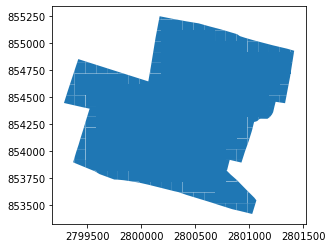

In [243]:
sub_g.plot()

In [253]:
sub_g_nc = gis.gp_polys_to_grids(sub_target_hs, side=100, no_grid_by_area=True, clip_by_poly=False, area_pcnt_thres=0.4)



sub_g_nc_area = sub_g_nc.area
d = cdist(sub_g_nc.centroid.apply(lambda x: x.coords[0]).tolist(), [sub_target_hs_centroid.coords[0]])[:,0]

i_g = (sub_g_nc_area**2)/6 + d** 2 * sub_g_nc_area
i_g = i_g.sum()

i_0 = sub_g_nc_area.sum()**2 / 2 / math.pi

i = i_0/i_g

i

0.8737884408674034

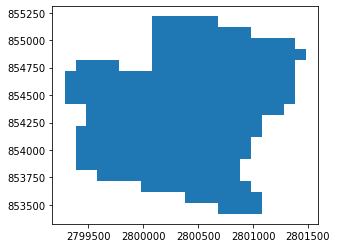

In [215]:

sub_g_nc.plot()

## average distance to a circle is 2R/3

https://math.stackexchange.com/questions/3019165/average-distance-from-center-of-circle

In [77]:
import math
import random
def rand_point_in_circle(radius):
    r = radius * math.sqrt(random.random())
    theta = random.random() * 2 * math.pi
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    return x, y

In [78]:

avg_dist = []
for rad in range(1, 20):
    dists = []
    for _ in range(100000):
        x1,y1=rand_point_in_circle(rad)
        dist = math.sqrt(x1**2+y1**2)
        dists.append(dist)
    avg_dist.append({'rad': rad, 'dist':sum(dists)/len(dists)})
avg_dist_pd = pd.DataFrame(avg_dist)

In [85]:
avg_dist_pd['ratio'] = avg_dist_pd.dist/avg_dist_pd.dist[0]
avg_dist_pd['rad**2'] = avg_dist_pd.rad**2
avg_dist_pd['ration/rad**2']=avg_dist_pd.ratio/avg_dist_pd['rad**2']
avg_dist_pd['ration/rad']=avg_dist_pd.ratio/avg_dist_pd['rad']
avg_dist_pd['dist/(2R/3)'] = avg_dist_pd.dist / (2*avg_dist_pd.rad/3)

In [86]:
avg_dist_pd

,rad,dist,ratio,rad**2,ration/rad**2,ration/rad,dist/(2R/3)
0,1,0.665913,1.000000,1,1.000000,1.000000,0.998870
1,2,1.335742,2.005880,4,0.501470,1.002940,1.001807
2,3,1.998839,3.001651,9,0.333517,1.000550,0.999420
3,4,2.668318,4.007005,16,0.250438,1.001751,1.000619
4,5,3.330542,5.001466,25,0.200059,1.000293,0.999163
5,6,4.003661,6.012287,36,0.167008,1.002048,1.000915
6,7,4.668991,7.011411,49,0.143090,1.001630,1.000498
7,8,5.331069,8.005652,64,0.125088,1.000706,0.999575
8,9,5.999499,9.009431,81,0.111228,1.001048,0.999916
9,10,6.663433,10.006459,100,0.100065,1.000646,0.999515


## average distance-square of a circle is ~ radius**2

### random sampling

In [7]:
import math
import random

In [29]:
def rand_point_in_circle(radius):
    r = radius * math.sqrt(random.random())
    theta = random.random() * 2 * math.pi
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    return x, y

In [45]:

avg_dist = []
for rad in range(1, 20):
    dist_squares = []
    dists = []
    for _ in range(100000):
        x1,y1=rand_point_in_circle(rad)
        x2,y2=rand_point_in_circle(rad)

        dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
        dist_square=(x1-x2)**2 + (y1-y2)**2
        dists.append(dist)
        dist_squares.append(dist_square)

    avg_dist.append({'rad': rad, 'dist':sum(dists)/len(dists), 'dist_2':sum(dist_squares)/len(dist_squares)})

In [54]:
avg_dist_pd = pd.DataFrame(avg_dist)

In [57]:
avg_dist_pd['ratio'] = avg_dist_pd.dist_2/avg_dist_pd.dist_2[0]
avg_dist_pd['rad**2'] = avg_dist_pd.rad**2
avg_dist_pd['ration/rad**2']=avg_dist_pd.ratio/avg_dist_pd['rad**2']

In [58]:
# http://mathworld.wolfram.com/DiskLinePicking.html: average distance is 128/45/pi ~= 0.905
avg_dist_pd

,rad,dist,dist_2,ratio,rad**2,ration/rad**2
0,1,0.905992,1.002213,1.000000,1,1.000000
1,2,1.813226,4.006565,3.997720,4,0.999430
2,3,2.715005,8.989880,8.970032,9,0.996670
3,4,3.625679,16.026201,15.990818,16,0.999426
4,5,4.522896,24.957895,24.902792,25,0.996112
5,6,5.443927,36.139776,36.059985,36,1.001666
6,7,6.333444,48.864130,48.756246,49,0.995025
7,8,7.230904,63.721727,63.581040,64,0.993454
8,9,8.148899,80.977775,80.798989,81,0.997518
9,10,9.059164,100.137692,99.916605,100,0.999166


### uniform grids

In [5]:
from shapely.geometry import Point

In [6]:
radius = 1
circle = Point(0,0).buffer(radius)


In [16]:
grids, _, _ = gis.poly2grids(circle, 0.01)
n = len(grids)
n

31748

In [17]:
grids = gp.GeoDataFrame(grids, columns=['geometry'])

grids.crs = mex.crs

In [18]:
dist = gis.polys_centroid_pairwise_dist(grids, mex.crs)

In [19]:
dist.sum()/n/(n-1)

0.9101091770815215

In [20]:
(dist**2).sum()/n/(n-1)

1.0103499818000863

In [42]:
len(dist)

31748

In [44]:
len(g)

32974

# hotspot

In [6]:
import src.ftrs.hotspot as ftrs_hs
from shapely.ops import cascaded_union
from shapely.geometry import Point
from scipy.spatial.distance import cdist


In [7]:

mg_mappings = region.ageb_ids_per_mpa()
zms = region.mpa_all()
zms['Area'] = zms.area

print('loading agebs')
zms_mun_ids = mg_mappings.mun_id.unique()
zms_loc_ids = mg_mappings.loc_id.unique()
zms_agebs = region.agebs(zms_mun_ids, zms_loc_ids)


loading agebs


In [8]:
by = 'area'
t2a = tw_int.to_mpa_agebs(by)
t2a.set_index('ageb', inplace=True)
avg_a = tw_int.interpolate_stats(avg_tw, t2a)

to_map_agebs loading existing file data/mex_tw_intpl/tower_to_mpa_agebs_by_area.csv


In [9]:
mg_mappings = region.ageb_ids_per_mpa()

In [10]:

for sun, zm_mapping in mg_mappings.groupby('CVE_SUN'):
    if sun!=13: continue
    print(sun, end=' ')
    zm = zms.loc[sun]
    zm_a = zms_agebs.loc[zm_mapping.ageb_id].copy()
    zm_avg_a = avg_a.loc[zm_a.index].copy()
    hs = ftrs_hs.HotSpot(zm_avg_a, zm_a, zm, 'loubar', verbose=1)
#     hs.calc_stats()
    break

13 

In [11]:
hs._get_hs()

masking out non hot spot, defined by loubar


In [12]:
hs_count = hs.hs_avg['23']
hs_count = hs_count[hs_count != 0]
target_hs = hs.geoms.loc[hs_count.index]
target_hs.shape

(287, 10)

In [13]:

hs_density = hs_count / target_hs.area
hs_density.name = 'Density'

In [14]:
hs_pair_d_avg = ftrs_hs.avg_dist(target_hs)  # distance among hotspots
comp_coef = ftrs_hs.compacity_coefficient(hs_pair_d_avg, hs.sqrt_area)


In [15]:
raster_rper = gis.gp_polys_to_grids(target_hs, pname=target_hs.index.name, side=hs.raster_resolution,
                                            no_grid_by_area=True, clip_by_poly=False, area_pcnt_thres=0.2)
raster_rper.crs = target_hs.crs
raster_rper = raster_rper.merge(hs_density.reset_index())
raster_rper['Area'] = raster_rper.area
raster_rper['Mass'] = raster_rper.Area * raster_rper.Density

In [16]:
rx = raster_rper.centroid.apply(lambda x: x.coords[0][0])
ry = raster_rper.centroid.apply(lambda x: x.coords[0][1])
cx = (rx * raster_rper.area).sum() / raster_rper.area.sum()
cy = (ry * raster_rper.area).sum() / raster_rper.area.sum()
raster_centroid = (cx, cy)
cx = (rx * raster_rper.Mass).sum() / raster_rper.Mass.sum()
cy = (ry * raster_rper.Mass).sum() / raster_rper.Mass.sum()
raster_mass_centroid = (cx, cy)

In [17]:
raster_centroid, raster_mass_centroid

((2802838.630070279, 831577.5548461049),
 (2804069.1091457065, 830895.5278110282))

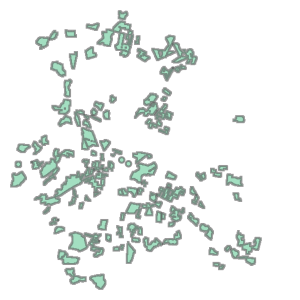

In [18]:
cascaded_union(raster_rper.geometry.tolist()+
               [Point(raster_centroid).buffer(500), 
                Point(raster_mass_centroid).buffer(500)])

In [19]:

raster_rper_centroids = raster_rper.centroid.apply(lambda x: x.coords[0]).tolist()

# rasterize pairwise and to centroid distance
pairwise_dist_square_avg = ftrs_hs.avg_dist_square(raster_rper)
d2centroid = cdist(raster_rper_centroids, [raster_centroid])[:,0]
d2centroid_avg = d2centroid.mean()
d2mass_centroid = cdist(raster_rper_centroids, [raster_mass_centroid])[:,0]
d2mass_centroid_avg = d2mass_centroid.mean()

In [20]:
d2centroid_avg

15160.578122130326

In [50]:
d2mass_centroid

array([24043.42422689, 24141.47266889, 24239.53705605, ...,
        4754.13884009,  4895.49113499,  4823.12301091])

In [21]:

ref_circle_radius = np.sqrt(raster_rper.Area.sum() / np.pi)
coh = ftrs_hs.cohesion(ref_circle_radius, pairwise_dist_square_avg)
prox = ftrs_hs.proximity(ref_circle_radius, d2centroid_avg)
nmi = ftrs_hs.moment_inertia(raster_rper.Area, d2centroid)

In [59]:
IGs, md2s, density_area2, sum_min_pij_aij = ftrs_hs.mass_moment_inertia(raster_rper, d2mass_centroid)



In [132]:
(density_area2+sum_min_pij_aij)/(IGs.sum() + md2s.sum()) / 2 /np.pi

0.13581026888337505

In [62]:
sum_min_pij_aij

6069690422230.41

In [66]:
import src.utils.map_vis as mvis

In [67]:
raster_rper['color'] = raster_rper.Mass/raster_rper.Mass.max()

In [69]:

print('building map')
m = folium.Map(location=[mex.clat, mex.clon], zoom_start=5)
mvis.geojson_per_row_color_col(
    raster_rper.to_crs(epsg=4326), name='raster_rper', 
    tip_cols=['ageb_id', 'Mass', 'color'], color_col='color', some_map=m)


folium.LayerControl().add_to(m)
m.save('raster_rper.html')

building map


## test case for NMI and NMMI

In [70]:
from shapely.geometry import box

In [165]:
data = []
for i in range(10):
    for j in range(10):
        shap = box(i, j, i+1, j+1)
        data.append({'i':i, 'j':j, 'geometry':shap})

data = gp.GeoDataFrame(data)

In [166]:
data['Area'] = data.area

In [167]:
rx = data.centroid.apply(lambda x: x.coords[0][0])
ry = data.centroid.apply(lambda x: x.coords[0][1])
cx = (rx * data.area).sum() / data.area.sum()
cy = (ry * data.area).sum() / data.area.sum()
data_centroid = (cx, cy)
data_centroid

(5.0, 5.0)

In [168]:
data_centroid_centroids = data.centroid.apply(lambda x: x.coords[0]).tolist()

data_d2centroid = cdist(data_centroid_centroids, [data_centroid])[:,0]

In [120]:
%matplotlib inline

In [197]:

data['type1'] = data.apply(lambda row: row.j== 4 or row.j==5, axis=1)

data['type2'] = data.apply(lambda row: row.j>=4 and row.j<6 and row.i>=4 and row.i<6, axis=1)
def dtype3(row):
    i= row.i
    j= row.j
    return (j >=3 and j< 7 and (i==2 or i==7)) or (j>=2 and j<8 and i>=3 and i<7)
data['type3'] = data.apply(dtype3, axis=1)


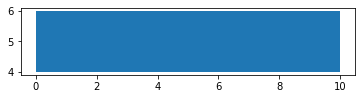

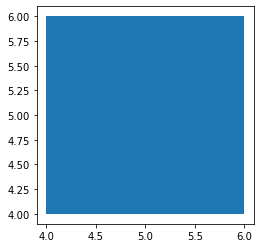

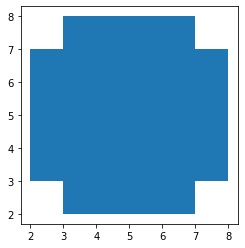

In [198]:
data[data['type1']].plot()
data[data['type2']].plot()


data[data.type3].plot()

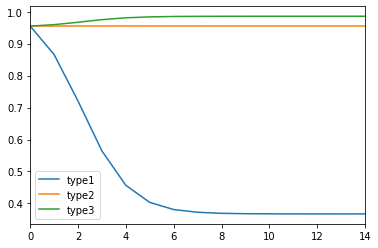

In [195]:
res = {}
for dentype in ['type1', 'type2', 'type3']:
    nmmis = []

    for i in range(15):
        density_coef = np.e**i
        data['Density'] = data[dentype].apply(lambda x: density_coef if x else 1)
        data['Mass'] = data.Area* data.Density
        cx = (rx * data.Mass).sum() / data.Mass.sum()
        cy = (ry * data.Mass).sum() / data.Mass.sum()
        data_mass_centroid = (cx, cy)
        assert np.isclose(data_mass_centroid, data_centroid).mean()==1
        nmmis.append(ftrs_hs.mass_moment_inertia(data, data_d2centroid))
    res[dentype] = nmmis

pd.DataFrame(res).plot()


In [196]:
pd.DataFrame(res)

,type1,type2,type3
0,0.954930,0.95493,0.954930
1,0.865837,0.95493,0.959416
2,0.720337,0.95493,0.966879
3,0.564155,0.95493,0.975087
4,0.456668,0.95493,0.980857
5,0.403264,0.95493,0.983762
6,0.380994,0.95493,0.984981
7,0.372393,0.95493,0.985453
8,0.369171,0.95493,0.985630
9,0.367977,0.95493,0.985696
